# **Data Visualization**
---

## Objectives

* Answer business requirement 1: 
    * The client is interested in visually differentiating animal species using image data.


## Inputs

* inputs/datasets/animals/image/train/
* inputs/datasets/animals/image/test/
* inputs/datasets/animals/image/validation/

## Outputs

* Image shape embeddings pickle file.
* Plots showing mean and variability of images per species.
* Plots highlighting differences between average species images.
* Code to generate an image montage, which can later be reused in the Streamlit dashboard.


## Additional Comments | Insights | Conclusions

* Processing large image datasets can cause memory crashes (especially when loading all species at once).

* To prevent this:

    * Limit the number of images per species.
    * Downscale images during exploration.
    * Use random sampling to display only a subset of species at a time.
    * Always close figures with plt.close(fig) to release memory.

---

## Set Data Directory
---

Import libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

Set working directory

In [3]:
cwd = os.getcwd()
os.chdir('/workspaces/Animal_detection_camera')
print("You set a new current directory")

work_dir = os.getcwd()
work_dir

You set a new current directory


'/workspaces/Animal_detection_camera'

### Set input directories
* Set train, test, and validation paths.

In [4]:
my_data_dir = 'inputs/datasets/animals/image'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [5]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available, create a new version.')
    pass
else:
    os.makedirs(name=file_path)


Old version is already available, create a new version.


### Set Species labels

In [6]:
labels = os.listdir(train_path)
print('Labels for the images are:', labels)

Labels for the images are: ['lemur', 'snake', 'elephant', 'frog', 'chimpanzee', 'chinchilla', 'flamingo', 'mongoose', 'ostrich', 'ferret', 'camel', 'bee', 'mole', 'penguin', 'leopard', 'hawk', 'hedgehog', 'walrus', 'falcon', 'grasshopper', 'beaver', 'antelope', 'giraffe', 'duck', 'lizard', 'crab', 'goose', 'gorilla', 'jaguar', 'sheep', 'lynx', 'butterfly', 'panda', 'goat', 'deer', 'peacock', 'dog', 'whale', 'kangaroo', 'seal', 'cheetah', 'cow', 'iguana', 'hippopotamus', 'fox', 'cat', 'donkey', 'raccoon', 'blackbird', 'buffalo', 'koala', 'crocodile', 'dolphin', 'hyena', 'porcupine', 'bear', 'squid', 'spider', 'eagle', 'bison', 'owl', 'otter', 'snail', 'wolf']


---

# Data Visualization of Image Data
---

## Image shape

Compute average images images size on train set.

In [7]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

Width average: 512 
Height average: 512


Set standard image shape as originals are too large

In [8]:
image_shape = (128, 128, 3)
print("Image shape set to:", image_shape)

Image shape set to: (128, 128, 3)


Save image shape

In [9]:
joblib.dump(value=image_shape,
    filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Average and Variability of Images  per Breed
---

### Function to load images in an array (tensor)

In [10]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(128, 128), n_images_per_label=20):
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            if counter < n_images_per_label:
                img = image.load_img(my_data_dir + '/' + label + '/' + image_filename,
                    target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                    new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1
    return X, y

2025-09-19 13:37:18.436636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Load image shapes and labels in an array

In [11]:
X, y = load_image_as_array(my_data_dir=train_path,
    new_size=image_shape,
    n_images_per_label=5)
print(X.shape, y.shape)

(320, 128, 128, 3) (320,)


Plot and save mean and variability of images per breed

==== Label snail ====
Image Shape: (128, 128, 3)


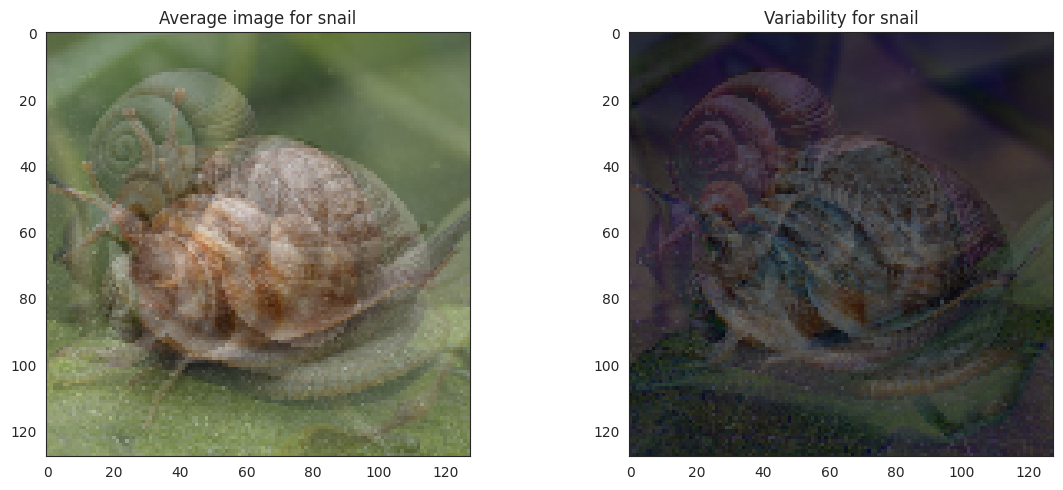



==== Label bison ====
Image Shape: (128, 128, 3)


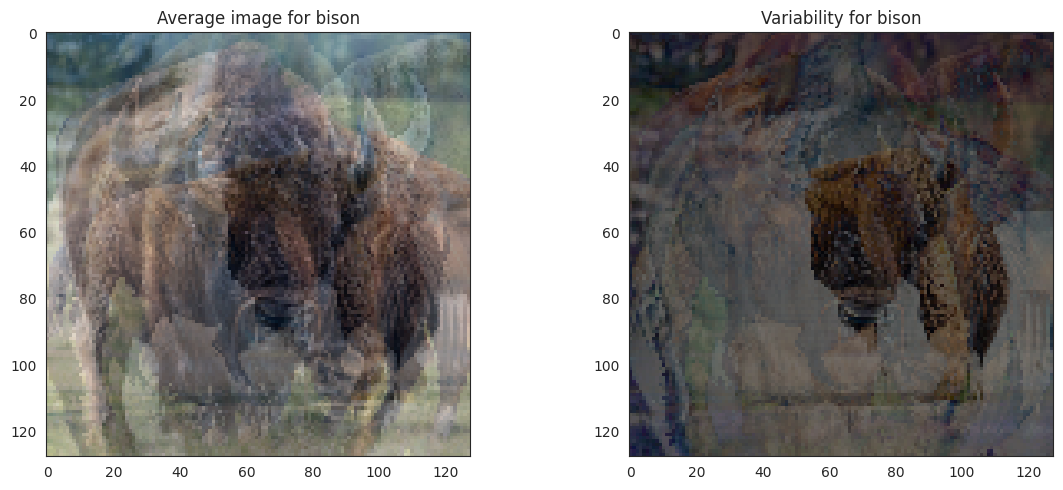



==== Label whale ====
Image Shape: (128, 128, 3)


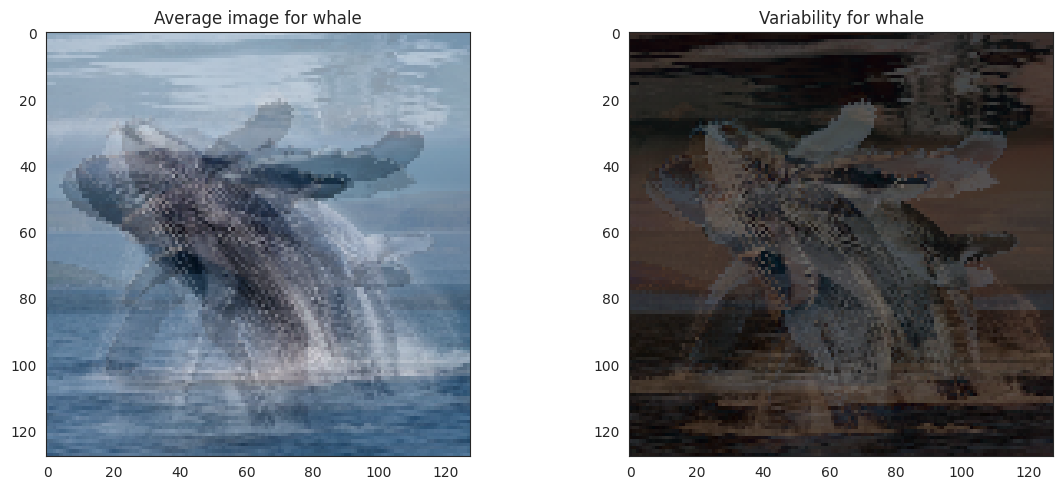



==== Label duck ====
Image Shape: (128, 128, 3)


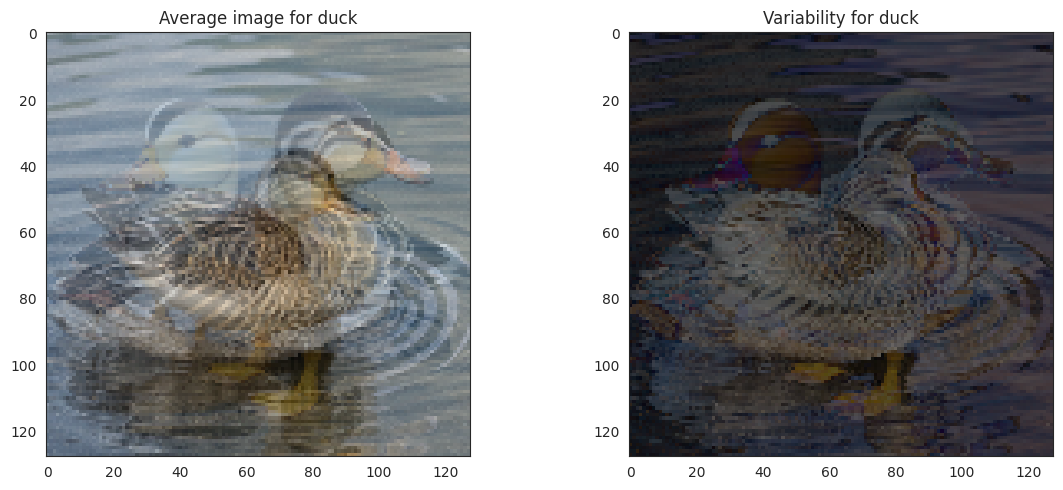



==== Label hyena ====
Image Shape: (128, 128, 3)


In [19]:
import random

def plot_mean_variability_random_labels(X, y, n_labels=5, figsize=(12, 5), save_image=False):
    unique_labels = list(np.unique(y))
    sampled_labels = random.sample(unique_labels, min(n_labels, len(unique_labels)))

    for label_to_display in sampled_labels:
        sns.set_style("white")

        y_loop = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y_loop == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        if arr.shape[0] == 0:
            print(f"No images found for {label_to_display}, skipping.")
            continue

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)

        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability for {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
            plt.close(fig)
        else:
            plt.tight_layout()
            plt.show()
            plt.close(fig)
            print("\n")

# Show random 5 species only
plot_mean_variability_random_labels(X=X, y=y, n_labels=5, figsize=(12, 5), save_image=False)

---

## Difference Between Average Species Images
---

In [13]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    return X[boolean_mask]

def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2,
                                            figsize=(20, 5), save_image=False):
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either {label_1} or {label_2} not in {np.unique(y)}")
        return

    # Averages
    label1_avg = np.mean(subset_image_label(X, y, label_1), axis=0)
    label2_avg = np.mean(subset_image_label(X, y, label_2), axis=0)

    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference: {label_1} vs {label_2}')

In [14]:
diff_bet_avg_image_labels_data_as_array(
    X=X, 
    y=y,
    label_1='antelope',
    label_2='beaver',
    figsize=(12, 10),
    save_image=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Image montage

In [15]:
import itertools
import random
sns.set_style("white")

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    labels = os.listdir(dir_path)
    if label_to_display in labels:
        images_list = os.listdir(dir_path + '/' + label_to_display)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()
    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")

Run montage for 5 random labels

owl


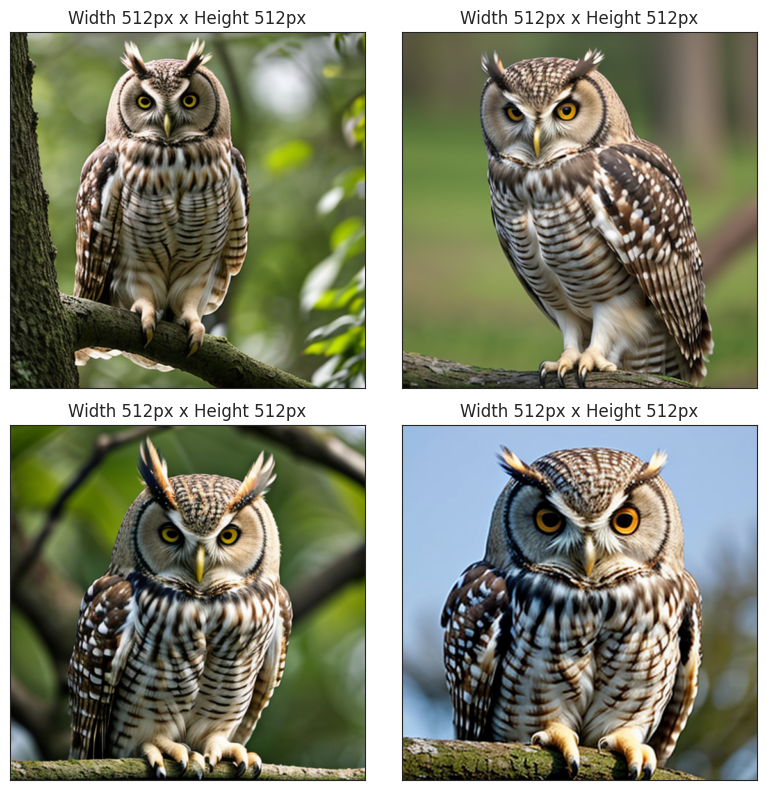



eagle


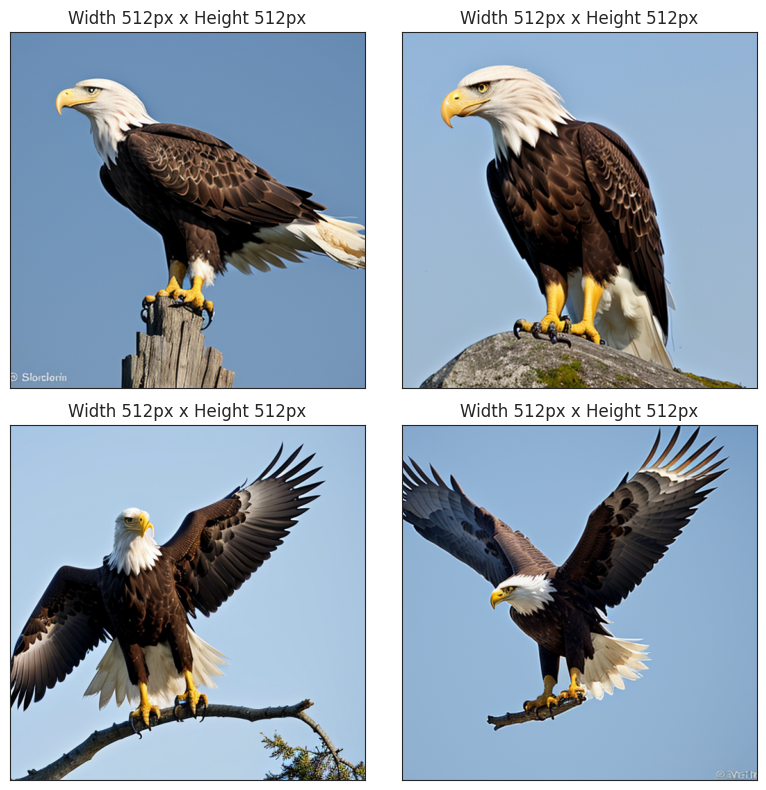



otter


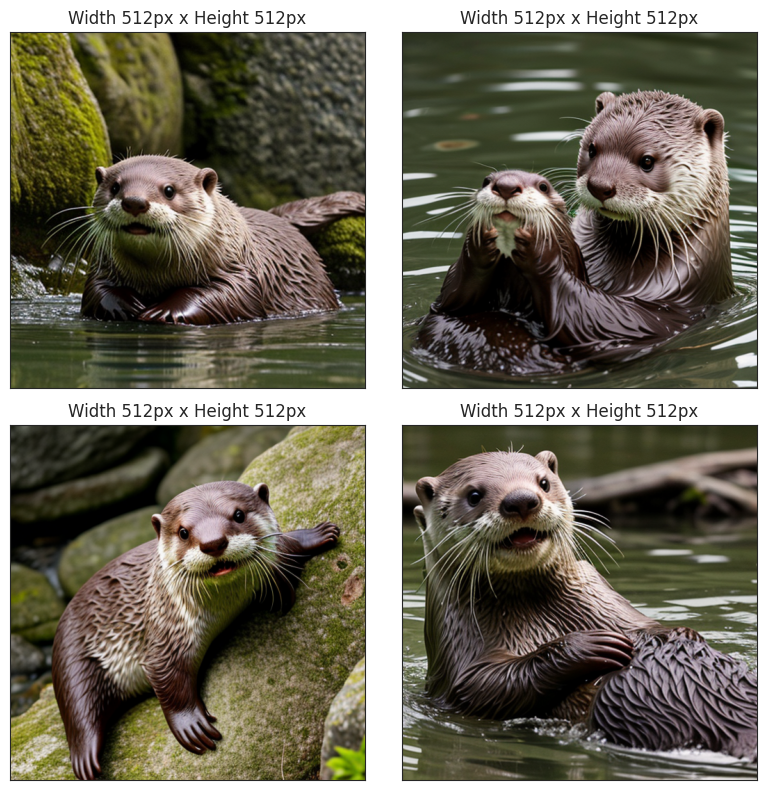



frog


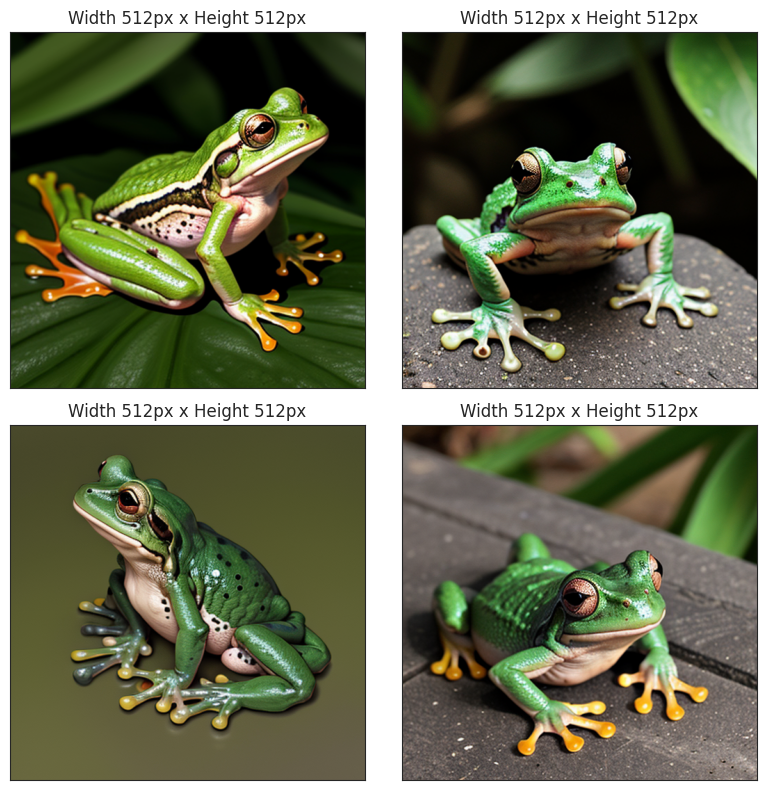



lemur


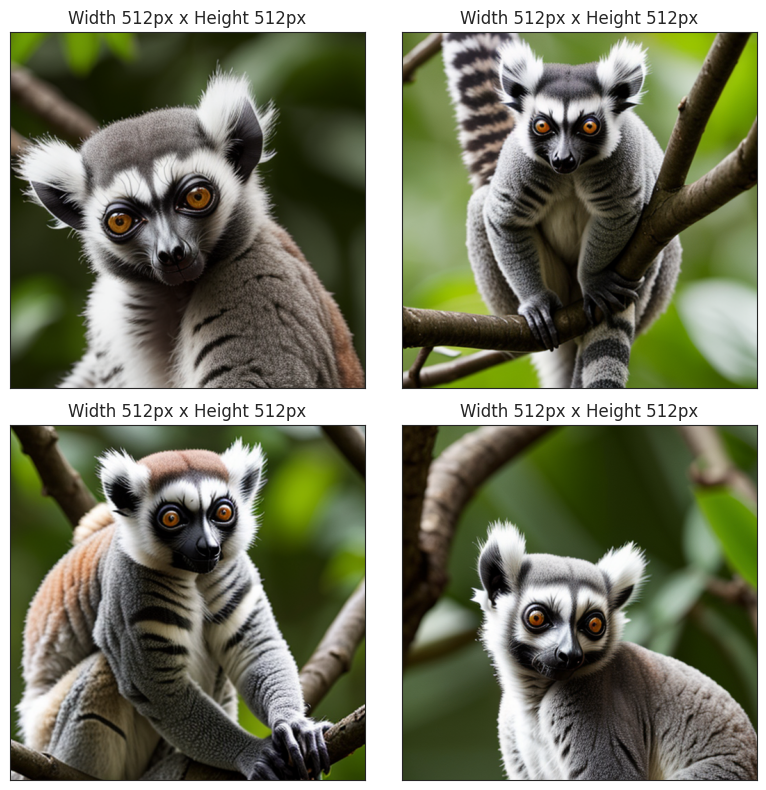

In [20]:
subset_labels = random.sample(labels, 5)

for label in subset_labels:
    print(label)
    image_montage(dir_path=train_path,
        label_to_display=label,
        nrows=2, ncols=2,
        figsize=(8, 8)
    )
    print("\n")